In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import random

In [18]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Flatten 28x28 images to 784 features, then a hidden layer of 128 neurons, and output 10 classes
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # Flatten the image tensor
        x = x.view(-1, 28 * 28)
        # Apply first linear layer and ReLU activation
        x = torch.relu(self.fc1(x))
        # Second layer returns the logits for each of the 10 classes
        x = self.fc2(x)
        return x
    

In [19]:
class Worker():
    def __init__(self, model, device, worker_id, byzantine=False, malicious_mode=3):
        self.worker_id = worker_id
        self.device = device
        self.mini_grad = 0
        self.model = model
        self.byzantine = byzantine
        self.criterion = nn.CrossEntropyLoss()
        self.malicious_mode = malicious_mode


    def update_model(self, model):
        self.model = model

    def update_byzantine(self, byzantine):
        self.isbyzantine = byzantine

    def compute_gradient(self, data, targets):
        # Transférer les données sur le bon device
        data, targets = data.to(self.device), targets.to(self.device)
        # Réinitialiser les gradients locaux
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        print(f"worker: {self.worker_id}, loss: {loss}")
        loss.backward()  # Calcule et stocke les gradients dans .grad de chaque paramètre

        # Récupérer les gradients dans un dictionnaire
        gradients = {}
        if self.byzantine:
            if self.malicious_mode == 1:
                for name, param in self.model.named_parameters():
                    if param.grad is not None:
                        # On ajoute du bruit aléatoire aux gradients
                        param.grad *= 10 * torch.randn_like(param.grad)
            elif self.malicious_mode == 2:
                for name, param in self.model.named_parameters():
                    if param.grad is not None:
                        # On inverse les gradients
                        param.grad = -param.grad.clone()
            elif self.malicious_mode == 3:
                for name, param in self.model.named_parameters():
                    if param.grad is not None:
                        # On annule les gradients
                        param.grad += 5
            elif self.malicious_mode == 4:
                for name, param in self.model.named_parameters():
                    if param.grad is not None:
                        # On annule les gradients
                        param.grad = torch.randn_like(param.grad)
                
        for name, param in self.model.named_parameters():
            if param.grad is not None:
                # On clone pour éviter les références directes
                gradients[name] = param.grad.detach().clone()
            else:
                gradients[name] = None
        return gradients

    def get_grad(self):
        return self.mini_grad

In [20]:
class Server:
    def __init__(self, lr=0.001):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Modèle global
        self.model = SimpleNN().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()


    def average_gradients(self, grad_list):
        """Fait la moyenne des gradients récupérés de tous les workers."""
        avg_gradients = {}
        # On suppose que chaque worker retourne un dictionnaire avec les mêmes clés
        for key in grad_list[0].keys():
            # Récupérer la liste des gradients pour ce paramètre (en ignorant ceux qui sont None)
            grads = [g[key] for g in grad_list if g[key] is not None]
            if grads:
                avg_gradients[key] = sum(grads) / len(grads)
            else:
                avg_gradients[key] = None
        return avg_gradients

    def update_global_model(self, avg_gradients):
        """Attribue les gradients moyennés au modèle global et effectue une mise à jour."""
        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            if name in avg_gradients and avg_gradients[name] is not None:
                param.grad = avg_gradients[name]
        self.optimizer.step()



In [ ]:
class Case:
    def __init__(self, Server, num_workers=2, pourcentage_byzantine=0, train_loader=None, num_epochs=1, workers=[]):
        self.server = Server
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_workers = num_workers
        self.train_loader = train_loader
        self.num_epochs = num_epochs
        
        self.workers = workers
        self.workers += self.create_workers(self.server.model, self.device, self.num_workers, pourcentage_byzantine)
        # Synchroniser les modèles des workers avec le modèle global
        self.sync_workers()


    def create_workers(self, model, device, num_workers, percentage_byzantine):
        workers = []
        num_byzantine = int(num_workers * percentage_byzantine / 100)
        # Sélectionne aléatoirement les indices qui seront byzantins
        byzantine_indices = set(random.sample(range(num_workers), num_byzantine))
        
        for i in range(num_workers):
            is_byzantine = (i in byzantine_indices)
            worker = Worker(model=model, device=device, worker_id=i, byzantine=is_byzantine)
            workers.append(worker)
            print(f"Worker {i+1} byzantin : {is_byzantine}")
        return workers

    def sync_workers(self):
        """Synchronise les poids des modèles des workers avec le modèle global."""
        global_state = self.server.model.state_dict()
        for worker in self.workers:
            worker.model.load_state_dict(global_state)

    def train(self):
        self.server.model.train()
        for epoch in range(self.num_epochs):
            for batch_idx, (data, targets) in enumerate(self.train_loader):
                # Partitionner la mini-batch entre les workers
                mini_batches = torch.chunk(data, self.num_workers)
                mini_targets = torch.chunk(targets, self.num_workers)
                grad_list = []
                
                
                for worker, mini_data, mini_target in zip(self.workers, mini_batches, mini_targets):
                    gradients = worker.compute_gradient(mini_data, mini_target)
                    grad_list.append(gradients)
                
                # Agréger (moyenner) les gradients reçus des workers
                avg_gradients = self.server.average_gradients(grad_list)
                # Mettre à jour le modèle global avec les gradients moyennés
                self.server.update_global_model(avg_gradients)
                # Synchroniser à nouveau les workers avec le modèle global mis à jour
                self.sync_workers()

                if batch_idx % 200 == 0:
                    print(f"Epoch {epoch+1}, Batch {batch_idx} : Mise à jour du modèle global")
        print("Entraînement distribué terminé sur le Server!")

In [22]:
# Define transforms for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the training and test datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


if __name__ == "__main__":
    server = Server(lr=0.001)
    case = Case(server, num_workers=10, train_loader=train_loader, num_epochs=2, pourcentage_byzantine=0)

    case.train()


Worker 1 byzantin : False
Worker 2 byzantin : False
Worker 3 byzantin : False
Worker 4 byzantin : False
Worker 5 byzantin : False
Worker 6 byzantin : False
Worker 7 byzantin : False
Worker 8 byzantin : False
Worker 9 byzantin : False
Worker 10 byzantin : False
worker: 0, loss: 2.2608389854431152
worker: 1, loss: 2.453082799911499
worker: 2, loss: 2.2857940196990967
worker: 3, loss: 2.373203754425049
worker: 4, loss: 2.444110631942749
worker: 5, loss: 2.2898783683776855
worker: 6, loss: 2.392486810684204
worker: 7, loss: 2.345620632171631
worker: 8, loss: 2.2575299739837646
worker: 9, loss: 2.80964994430542
Epoch 1, Batch 0 : Mise à jour du modèle global
worker: 0, loss: 2.0345685482025146
worker: 1, loss: 2.3300414085388184
worker: 2, loss: 2.1327450275421143
worker: 3, loss: 2.280214548110962
worker: 4, loss: 2.1537585258483887
worker: 5, loss: 2.1225244998931885
worker: 6, loss: 2.1304595470428467
worker: 7, loss: 2.2270169258117676
worker: 8, loss: 2.1914074420928955
worker: 9, loss

KeyboardInterrupt: 

In [ ]:
def test(model):

    # Testing loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            outputs = model(data)
            # The class with the highest score is chosen as prediction
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

test(server.model)

Test Accuracy: 96.08%


tensor([[-7.9749,  7.6714, -2.2352, -1.0984, -4.9000, -4.4369, -2.7276, -0.9899,
         -1.4083, -3.3025]])


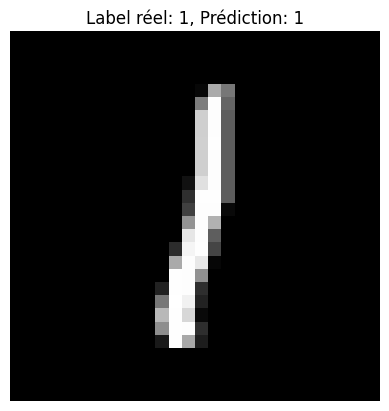

In [ ]:
import random

data_iter = iter(test_loader)
images, true_labels = next(data_iter)

random_idx = random.randint(0, images.size(0) - 1)

# Sélection de l'image et du label correspondant
image = images[random_idx]
true_label = true_labels[random_idx]


with torch.no_grad():
    output = server.model(image)
    print(output)
    predicted_label = torch.argmax(output, dim=1).item()

# Pour afficher l'image, il faut annuler la normalisation et retirer la dimension du batch
# On récupère l'image sous forme de tableau
image_to_show = image.squeeze()  # Retire la dimension du batch et du canal (si en niveaux de gris)

# Affichage avec matplotlib
plt.imshow(image_to_show, cmap='gray')
plt.title(f"Label réel: {true_label.item()}, Prédiction: {predicted_label}")
plt.axis('off')
plt.show()